In [9]:
import pandas as pd
import numpy as np 

In [12]:
DATA_PATH = 'Data/'
vgd_data = DATA_PATH+'video_game.csv'

In [13]:
vgd_master = pd.read_csv(vgd_data)

In [14]:
#Lets change all the names of the columns to lowercase
vgd_master.columns = vgd_master.columns.str.lower()
vgd = vgd_master
vgd.dtypes

unnamed: 0           int64
name                object
platform            object
year_of_release    float64
genre               object
publisher           object
na_players         float64
eu_players         float64
jp_players         float64
other_players      float64
global_players     float64
critic_score       float64
critic_count       float64
user_score          object
user_count         float64
developer           object
rating              object
dtype: object

In [15]:
#Before I can split I actually have to deal with NAN values
#If I have more time/if I want to come back to this I can try using an api to gather missing data 

#Target column (critic_score)
vgd = vgd.drop(vgd[vgd.critic_score.isna()].index)

#year_of_release
vgd = vgd.drop(vgd[vgd.year_of_release.isna()].index)

#rating:
vgd = vgd.drop(vgd[vgd.rating.isna()].index)

#publisher:
vgd = vgd.drop(vgd[vgd.publisher.isna()].index)

In [16]:
# I'm going to drop user_score, user_count, and critic_count columns because they are leaky.

vgd.isna().sum()

unnamed: 0            0
name                  0
platform              0
year_of_release       0
genre                 0
publisher             0
na_players            0
eu_players            0
jp_players            0
other_players         0
global_players        0
critic_score          0
critic_count          0
user_score           24
user_count         1076
developer             0
rating                0
dtype: int64

In [17]:
vgd.shape

(7901, 17)

In [18]:
#Train Test Split:
from sklearn.model_selection import train_test_split
test_size = 0.127
train, test = train_test_split(vgd,test_size = test_size)
val_size=0.15
train,val = train_test_split(train,test_size = val_size)
train.shape,val.shape,test.shape


((5862, 17), (1035, 17), (1004, 17))

In [19]:
def wrangle(X):
    #To Avoid warning (?)
    X = X.copy()
    
    #Drop index column
    X = X.drop('unnamed: 0',1)
    
    #Drop year_of_release nans
    yor_drop = X[X.year_of_release.isna()].index.to_list()
    X = X.drop(yor_drop)
    
    #For now drop all the 
    
    return X

train = wrangle(train)
test = wrangle(test)
val = wrangle(val)

In [20]:
train.shape

(5862, 16)

# Exploration

TOC for explore. I made a copy of the df for each iteration, the problem with this would be memory management for much larger datasets, but I'm not sure if there are some optimizations going in the background. (querying a single database  in memory, and returning the results, or actually creating a copy to place  in memory? What is happening in the hardware?)


df:usage...


explore: plotting the difference between user and critic scores.

## User vs Critic Scores

In [21]:
import seaborn as sns

In [22]:
#User score vs critic score:
#Lets get rid of nans
explore = train
explore.shape

(5862, 16)

In [23]:
explore = explore.dropna(subset = ['user_count','critic_count'])
explore.shape

(5057, 16)

In [24]:
explore.critic_score = explore.critic_score/10

G:\Apps\Anaconda3\envs\u2build\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [25]:
explore.user_score = explore.user_score.astype(float)

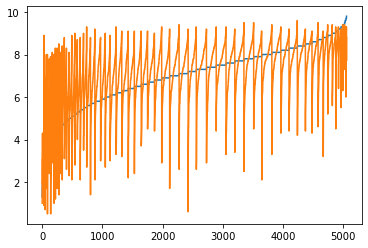

In [26]:
x = list(range(len(explore)))
y1 = explore.critic_score.to_list()
y2 = explore.user_score.to_list()

y1, y2 = zip(*sorted(zip(y1,y2)))

# the other way to do this is probably through sortby in pandas

sns.lineplot(x = x, y = y1, data= explore)
sns.lineplot(x = x, y = y2, data = explore)

This tells me that user and critic scores don't really track. This may be due to a bias in the way that these scores are collected. 

I would guess that on average the closer a game is to average the better the scores line up compared to the ends

It does seem like every "step" of a crtitic_score has a range of possible values for user_score. I can look at the spread of user for every critic, and see if I can glean some information from that.  (I do this below)

This does provide an interesting feature for a different model/ maybe one for this model. We could look at if the critic score, and the user score match for specific games. And we could set that as the target for the model. This model would then produce the boolean/number that describes the difference between critic score and normal score, and then it could be used in another model to predict the critic score. You wouldn't have leakage because each model is still working on the base input information. I also don't think that the value would be a huge predictor because the error associated with the first model would be noise in the second model. The feature wouldn't track perfectly becuase the value that its using is an imperfect value. If there is a manual way to tone down the effects of that specific feature I could also ensure that the feature isn't overused by dampening the effects of my "engineered" feature in the model.

In [27]:
#Pandas sortby test:
explore.sort_values("critic_score").head()
#From here I can just take critic score, and user score turn them into lists
#and send them to my graphing function. Might be more memory efficient my previous 
#way.

,name,platform,year_of_release,genre,publisher,na_players,eu_players,jp_players,other_players,global_players,critic_score,critic_count,user_score,user_count,developer,rating
13690,Ride to Hell,PS3,2013.0,Racing,Deep Silver,0.02,0.01,0.0,0.01,0.04,1.3,4.0,1.0,218.0,"Eutechnyx, Deep Silver",M
10663,Leisure Suit Larry: Box Office Bust,PS3,2009.0,Adventure,Codemasters,0.06,0.03,0.0,0.01,0.10,1.7,11.0,1.7,37.0,Team 17,M
7219,Nickelodeon Party Blast,XB,2002.0,Misc,Infogrames,0.16,0.05,0.0,0.01,0.22,1.9,4.0,4.3,7.0,Data Design Interactive,E
10016,Rugby 15,PS4,2015.0,Sports,Bigben Interactive,0.04,0.06,0.0,0.02,0.11,1.9,5.0,3.4,65.0,HB Studios Multimedia,E
15345,Balls of Fury,Wii,2007.0,Sports,Zoo Digital Publishing,0.02,0.00,0.0,0.00,0.02,1.9,6.0,2.8,25.0,Black Lantern Studios,E10+


In [28]:
explore.critic_score.unique().shape 
#There are only 80 "steps" to the graph. 

(80,)

In [29]:
critic_score_values = sorted(explore.critic_score.unique())
# critic_score_values

In [30]:
type(critic_score_values[0])

numpy.float64

In [31]:
critic_score_value = 1.9
mask = explore.critic_score==critic_score_value
mask
a = explore[mask]

In [32]:
amean = a.user_score.mean()
amean

2.9

In [33]:
astd= a.user_score.std()
astd

1.0977249200050074

### Messing around with JSON

In [34]:
#Now I want to create a column with the mean user score and another with
#the stdev. lets put them into a dictionary first though.
#Actually lets try json and see if I can readjson on the resulting 
json_format = {critic_score_value:{"mean":amean,'std':astd}}
json_format[2] = {"mean":amean,'std':astd} #test add a new value

In [35]:
for k in json_format.keys():
    print(type(k))

<class 'float'>
<class 'int'>


In [36]:
#Lets put it all together in a function
json_format = {}
for val in critic_score_values:
    mask = explore.critic_score == val
    a = explore[mask]
    amean = a.user_score.mean()
    astd = a.user_score.std()
    json_format[val] = {"mean":amean,'std':astd}
json_format[0]

KeyError: 0

In [37]:
del json_format[1.3]
del json_format[1.7]

In [38]:
json_format

{1.9: {'mean': 2.9, 'std': 1.0977249200050074},
 2.0: {'mean': 2.5, 'std': 0.8485281374238571},
 2.3: {'mean': 2.9, 'std': 0.45825756949558394},
 2.4: {'mean': 3.5249999999999995, 'std': 0.5439056290693572},
 2.5: {'mean': 3.1599999999999997, 'std': 0.9528903399657277},
 2.6: {'mean': 3.3, 'std': 0.6557438524302001},
 2.7: {'mean': 5.4, 'std': 2.546893532652409},
 2.8: {'mean': 3.225, 'std': 1.4119388898147924},
 2.9: {'mean': 3.9499999999999997, 'std': 0.9192388155425116},
 3.0: {'mean': 4.266666666666667, 'std': 1.4746751054610867},
 3.1: {'mean': 4.95, 'std': 0.412310562561766},
 3.2: {'mean': 3.2874999999999996, 'std': 1.5018441045214093},
 3.3: {'mean': 5.4, 'std': 1.7677669529663689},
 3.4: {'mean': 4.383333333333334, 'std': 2.2247846337716974},
 3.5: {'mean': 5.072727272727272, 'std': 1.478574251832426},
 3.6: {'mean': 3.8666666666666667, 'std': 1.376157521437689},
 3.7: {'mean': 4.888888888888889, 'std': 1.2328297859176471},
 3.8: {'mean': 4.555000000000001, 'std': 1.5205521850

In [39]:
#Figured out json stuff from here:https://stackoverflow.com/questions/42825102/how-to-save-python-dictionary-into-json-files#42825194

import json

js = json.dumps(json_format)
fp = open("test.json",'w')

fp.write(js)
fp.close()

fr = open('test.json','r')
fr.read()


'{"1.9": {"mean": 2.9, "std": 1.0977249200050074}, "2.0": {"mean": 2.5, "std": 0.8485281374238571}, "2.3": {"mean": 2.9, "std": 0.45825756949558394}, "2.4": {"mean": 3.5249999999999995, "std": 0.5439056290693572}, "2.5": {"mean": 3.1599999999999997, "std": 0.9528903399657277}, "2.6": {"mean": 3.3, "std": 0.6557438524302001}, "2.7": {"mean": 5.4, "std": 2.546893532652409}, "2.8": {"mean": 3.225, "std": 1.4119388898147924}, "2.9": {"mean": 3.9499999999999997, "std": 0.9192388155425116}, "3.0": {"mean": 4.266666666666667, "std": 1.4746751054610867}, "3.1": {"mean": 4.95, "std": 0.412310562561766}, "3.2": {"mean": 3.2874999999999996, "std": 1.5018441045214093}, "3.3": {"mean": 5.4, "std": 1.7677669529663689}, "3.4": {"mean": 4.383333333333334, "std": 2.2247846337716974}, "3.5": {"mean": 5.072727272727272, "std": 1.478574251832426}, "3.6": {"mean": 3.8666666666666667, "std": 1.376157521437689}, "3.7": {"mean": 4.888888888888889, "std": 1.2328297859176471}, "3.8": {"mean": 4.555000000000001,

In [40]:
newdf = pd.read_json('test.json')
newdf.columns[0]
#The column headings are timestamps for some reason
#This aside this is a pretty good experiment

Timestamp('1970-01-01 00:00:01.900000')

### User/Critic difference graph

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
# critic_score_values

In [51]:
ameans = []
astds = []
for val in critic_score_values:
    mask = explore.critic_score == val
    a = explore[mask]
    amean = a.user_score.mean()
    astd = a.user_score.std()
    ameans.append(amean)
    astds.append(astd)
graph_zip = list(zip(critic_score_values,ameans,astds))

#slice doesn't work well here beacause I have a list of tuples not a list of lists
#but I can see that I have reasonable values by uncommenting the following:
# graph_zip

In [54]:
#plus and minus one std from mean
p1_std = list(np.array(ameans)+np.array(astds))
m1_std = list(np.array(ameans)-np.array(astds))
x = list(range(len(ameans)))

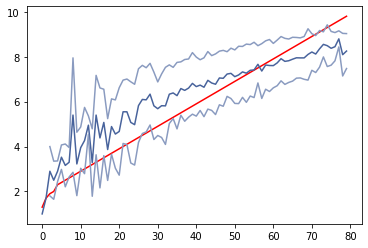

In [63]:
sns.lineplot(x,critic_score_values, color= 'red')
sns.lineplot(x,ameans, color = '#48639c')
# sns.lineplot(x,astds)
sns.lineplot(x,p1_std,color = '#8a9bc0')
sns.lineplot(x,m1_std,color = '#8a9bc0')
#Add a distribution on top of this to describe number of 
#values used to caluclate the mean
#Plot 1 : Less scores in the lower end of scores <- historgram plot
#Plot 2 the plot below:
#Scatter plot user on 1 axis and critic on another axis (use alpha/opacity) (apply some jitter?< gets rid of overlapping points for non-continousu variables)
#bivariant distribitions in seaborn (hexbin plot<-- try this?)

The above graph shows the relationship between critic scores (blue) and user scores (darker orange) along with +- 1 standard deviation from the user scores (lighter orange). Notice that on average user scores are higher for ratings below around 7/10, and lower for ratings above 7/10. Now this could be for a statistical reason. There are simply fewer scores below 6 than there are above 6 so there is more uncertainty associated with lower user scores. This uncertainty is reflected in the standard deviation curves. Aside from this bias the data can also be interpereted as follows. It seems like the games that critics love, the games that score the best according to critics are not appreciated by users. This could be for a variety of reasons. In some cases it may be that the "hype" for the game was overdone, leading to high expectations. When those expectations weren't met the 

Now I'm not completely sure which of these reasons is the truth, but if reason () is true that would mean that a truly great game should be given a slightly lower score in order to attract more users? 
Personally I have sometimes felt that the games I was supposed to like, the games that were "classics" didn't live up to my expectations, oftentimes the games I enjoy the most are the games that are unexpectedly good. Part of their value lies in the discovery of the game. My brain doesn't judge while I play, it just absorbs, and that makes the experience better for me.

In [46]:
train.head()

,name,platform,year_of_release,genre,publisher,na_players,eu_players,jp_players,other_players,global_players,critic_score,critic_count,user_score,user_count,developer,rating
5928,Spider-Man 3,PSP,2007.0,Platform,Activision,0.01,0.23,0.0,0.05,0.30,52.0,7.0,7.4,9.0,Treyarch,T
15332,Dragon's Lair,DS,2010.0,Platform,Destineer,0.02,0.00,0.0,0.00,0.02,63.0,4.0,tbd,NaN,"United Coders, Wizardry Engineering",E10+
2929,Omerta: City of Gangsters,X360,2011.0,Simulation,Konami Digital Entertainment,0.42,0.22,0.0,0.06,0.70,43.0,18.0,3.3,25.0,Kalypso,T
3100,Tiger Woods PGA Tour 09,PS3,2008.0,Sports,Electronic Arts,0.34,0.22,0.0,0.10,0.65,82.0,34.0,7.2,9.0,EA Tiburon,E
15071,Total Overdose: A Gunslinger's Tale in Mexico,XB,2005.0,Shooter,Eidos Interactive,0.02,0.01,0.0,0.00,0.02,71.0,28.0,9.2,27.0,Deadline Games,M


# Setting up for model

In [47]:
#Setting up matrices for models:

target = 'critic_score'
#the first three are leaky(ish) and "name" is high cardinality.
drop = ['critic_count','user_score','user_count','name','publisher','developer']
features = train.columns.drop(target)
features = features.drop(drop)
features

Index(['platform', 'year_of_release', 'genre', 'na_players', 'eu_players',
       'jp_players', 'other_players', 'global_players', 'rating'],
      dtype='object')

In [48]:
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

#Some verification:
train.shape,X_train.shape

G:\Apps\Anaconda3\envs\u2build\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after removing the cwd from sys.path.


IndexError: invalid index to scalar variable.

# Baseline

In [146]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

X_train.head()
y_baseline = [y_train.mean()]*len(y_val)

print(f'Mean absolute error: {mae(y_val,y_baseline)}')
print(f'R2 score: {r2_score(y_val,y_baseline)}')

Mean absolute error: 11.078776101543225
R2 score: -0.000958519320405582


# Model 1 (Tree Based Regression)

In [153]:
#High cardinality columns... might have to get rid of them or process them somehow.
# print('Uniques in "developer" column',len(train.developer.unique()))
# train.developer.unique()

# print('Uniques in "publisher" column',len(train.publisher.unique()))
# train.publisher.unique()

In [166]:
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV

process = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
)

X_train_processed = process.fit_transform(X_train)
X_val_processed = process.transform(X_val)

model = RandomForestRegressor(
    n_jobs = -2,
    n_estimators=100,
    criterion='mae',
    )

model.fit(X_train_processed,y_train)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-2,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [167]:
print('Training Error:', model.score(X_train_processed,y_train))
print('Validation Error:',model.score(X_val_processed,y_val))

Training Error: 0.8843375668854465
Validation Error: 0.29457678230718676


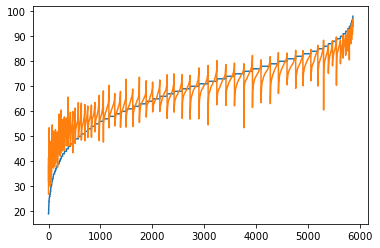

In [168]:
import seaborn as sns
#Visual Error observation:

a = y_train
p = model.predict(X_train_processed)
x = list(range(len(y_train)))

a1,p1 = zip(*sorted(zip(a,p)))

sns.lineplot(x,a1)
sns.lineplot(x,p1)


In [152]:
import shap

def shap_plot(row_number):
    row = X_train.iloc[[row_number]]
    row_processed = process.transform(row)
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(row_processed)
    
    shap.initjs()
    
    return shap.force_plot(
        base_value = explainer.expected_value,
        shap_values = shap_values,
        features = row,
    )

shap_plot(3972)

## Model 2 (Linear Regression)

In [154]:
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

process = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
)

X_train_processed = process.fit_transform(X_train)
X_val_processed = process.transform(X_val)

model = LinearRegression(
    n_jobs = -2,
    )

model.fit(X_train_processed,y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-2, normalize=False)

In [157]:
print('Training Error:', model.score(X_train_processed,y_train))
print('Validation Error:',model.score(X_val_processed,y_val))

Training Error: 0.05894365376010169
Validation Error: 0.06281115992863195


In [162]:
list(zip(X_train.columns,model.coef_))

[('platform', -0.018295644665735078),
 ('year_of_release', 0.052862119871249585),
 ('genre', 0.014482529638434235),
 ('na_players', 20.466184750532435),
 ('eu_players', 18.0088736678371),
 ('jp_players', 20.34490881801108),
 ('other_players', 19.636925647727015),
 ('global_players', -17.888437102862014),
 ('rating', -0.4935235749467634)]

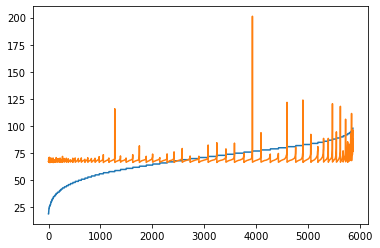

In [156]:
import seaborn as sns
#Visual Error observation:

a = y_train
p = model.predict(X_train_processed)
x = list(range(len(y_train)))

a1,p1 = zip(*sorted(zip(a,p)))

sns.lineplot(x,a1)
sns.lineplot(x,p1)